# Use Stan Model for Bayes Hierarchical RL
- Estimate learning rate (i.e. alpha) for each subject using this model

In [1]:
%config Completer.use_jedi = False

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import theano
import theano.tensor as tt
import scipy
import os
# import stan
import cmdstanpy
#import pymc3 as pm
import arviz as az
# import learning package
#import DMpy

In [2]:
# read scr file
scr = pd.read_csv('firstSCRpart.csv')
scr['sub'].unique()

array([ 189,   86,  205,   71,   87,  204,   85,   24,  101,  100,  132,
        185,  167,   43,   62,  105,   73,   82,   30,  160,  196,  146,
       1223,  106,    8,   94,  112,  169, 1222,   55,  170,  131,   47,
        177,   89,  130,  172,  200,  173,   26,   59,    1,   72, 1232,
        166,   32,   11,  104,   16, 1205,  186,   56,   53,  150,   65,
        154,  193,  165,    4,  103,   95,  168,   20,  102,   75,   48,
         27,    5,  136,  182,  202,  114,  121,   81,  203,  108,   80,
        122,   66,   38,  184,  171,  183,   13,   22,  179,  592,  153,
        144,  178,   63,  124,   21,   19,   10,  158,   83,  113,  107,
        126,  152])

In [3]:
# grab just two subjects for now
scrTwo = scr#[(scr['sub']==63) | (scr['sub']==113) | (scr['sub']==107) | (scr['sub']==80) |(scr['sub']==65) 
             #| (scr['sub']==171) |(scr['sub']==10)]
scrTwo['sub'].unique()

array([ 189,   86,  205,   71,   87,  204,   85,   24,  101,  100,  132,
        185,  167,   43,   62,  105,   73,   82,   30,  160,  196,  146,
       1223,  106,    8,   94,  112,  169, 1222,   55,  170,  131,   47,
        177,   89,  130,  172,  200,  173,   26,   59,    1,   72, 1232,
        166,   32,   11,  104,   16, 1205,  186,   56,   53,  150,   65,
        154,  193,  165,    4,  103,   95,  168,   20,  102,   75,   48,
         27,    5,  136,  182,  202,  114,  121,   81,  203,  108,   80,
        122,   66,   38,  184,  171,  183,   13,   22,  179,  592,  153,
        144,  178,   63,  124,   21,   19,   10,  158,   83,  113,  107,
        126,  152])

In [4]:
# organize data accordingly
# first, grab just the relevant variables (subject, trial, stimuli, shock)
# we need to generate a new variable shock (1=yes, 0=no)
# we also need a new variable stim (1=CS+, 2=CS-)
scrVec = scrTwo['CDA.AmpSum'].values
print(scrVec.shape)
shockVec = np.zeros(len(scrVec), dtype=np.int32) # vector to capture shock (1=yes, 0=no)
stimVec = np.zeros(len(scrVec), dtype=np.int32) # vector to capture stimulus (1=CS+, 2= CS-)

for i, cond in enumerate(scrTwo['Condition'].values):
    #print(i)
    if cond=='CSplusUS1':
        shockVec[i]= 1
        stimVec[i] = 1
    else:
        shockVec[i] = 0
        if cond=='CSminus1':
            stimVec[i] = 2
        else:
            stimVec[i] = 1
print(shockVec.shape)
print(stimVec.shape)
nTrials = 30 #len(scrTwo['Event.Nr']) # grab number of trials

(3030,)
(3030,)
(3030,)


In [5]:
n_subj = len(scrTwo['sub'].unique())
n_subj

101

In [6]:
Tsubj = [30] * n_subj
# create matrix for shocks (trials X Subject), scr (trials X subject) and stimulus (trials X subject)
stim = np.reshape(stimVec, (n_subj,30)).T # transform to matrix trials x subject
shock = np.reshape(shockVec, (n_subj,30)).T 
scrMat = np.reshape(scrVec, (n_subj,30)).T
scrVec

array([0.2852, 0.1033, 0.0783, ..., 0.    , 0.0501, 0.    ])

In [9]:
scrMat.shape

(30, 101)

In [10]:
data =  {'N': n_subj, 'T': 30, 'Tsubj': Tsubj, 'scr': scrMat, 'lambda':shock,
'stim': stim}
rw_bayes = cmdstanpy.CmdStanModel(stan_file='scr_model.stan')
#rw_bayes = cmdstanpy.CmdStanModel(stan_file='bayes_stan_rw.stan')


INFO:cmdstanpy:compiling stan program, exe file: /gpfs/ysm/home/oad4/amg_hippo_fc/scr_model
INFO:cmdstanpy:compiler options: stanc_options={}, cpp_options={}
INFO:cmdstanpy:compiled model file: /gpfs/ysm/home/oad4/amg_hippo_fc/scr_model


In [11]:
# Train the model and generate samples
seed = 1332 # set random seed
fit_simple_model = rw_bayes.sample(
  data = data,
  chains = 4,
  iter_warmup = 1000,
  iter_sampling = 1000,
  adapt_delta = .9,
  seed = seed
  #inits = 0.2,
)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 1


In [12]:
model = az.from_cmdstanpy(fit_simple_model)
az.summary(model, var_names=['A', 'mu_p'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
A[0],0.166,0.052,0.075,0.265,0.001,0.001,6358.0,2882.0,1.00
A[1],0.123,0.031,0.066,0.180,0.000,0.000,6485.0,2929.0,1.00
A[2],0.163,0.047,0.085,0.257,0.001,0.000,7008.0,2899.0,1.00
A[3],0.181,0.053,0.091,0.282,0.001,0.001,5419.0,2835.0,1.00
A[4],0.124,0.039,0.057,0.198,0.001,0.000,6038.0,3388.0,1.00
...,...,...,...,...,...,...,...,...,...
A[100],0.197,0.063,0.087,0.314,0.001,0.001,6037.0,2872.0,1.00
mu_p[0],-1.018,0.044,-1.096,-0.930,0.001,0.001,2373.0,2623.0,1.00
mu_p[1],-0.004,0.004,-0.012,0.004,0.000,0.000,2912.0,2454.0,1.00
mu_p[2],1.497,0.144,1.220,1.757,0.013,0.009,122.0,228.0,1.03


/gpfs/ysm/project/joormann/oad4/conda_envs/neuroAnalysis/lib/python3.9/site-packages/arviz/plots/plot_utils.py:271: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (101) in plot_posterior, generating only 40 plots
  warnings.warn(


array([[<AxesSubplot:title={'center':'A\n0'}>,
        <AxesSubplot:title={'center':'A\n1'}>,
        <AxesSubplot:title={'center':'A\n2'}>,
        <AxesSubplot:title={'center':'A\n3'}>],
       [<AxesSubplot:title={'center':'A\n4'}>,
        <AxesSubplot:title={'center':'A\n5'}>,
        <AxesSubplot:title={'center':'A\n6'}>,
        <AxesSubplot:title={'center':'A\n7'}>],
       [<AxesSubplot:title={'center':'A\n8'}>,
        <AxesSubplot:title={'center':'A\n9'}>,
        <AxesSubplot:title={'center':'A\n10'}>,
        <AxesSubplot:title={'center':'A\n11'}>],
       [<AxesSubplot:title={'center':'A\n12'}>,
        <AxesSubplot:title={'center':'A\n13'}>,
        <AxesSubplot:title={'center':'A\n14'}>,
        <AxesSubplot:title={'center':'A\n15'}>],
       [<AxesSubplot:title={'center':'A\n16'}>,
        <AxesSubplot:title={'center':'A\n17'}>,
        <AxesSubplot:title={'center':'A\n18'}>,
        <AxesSubplot:title={'center':'A\n19'}>],
       [<AxesSubplot:title={'center':'A\n20'}

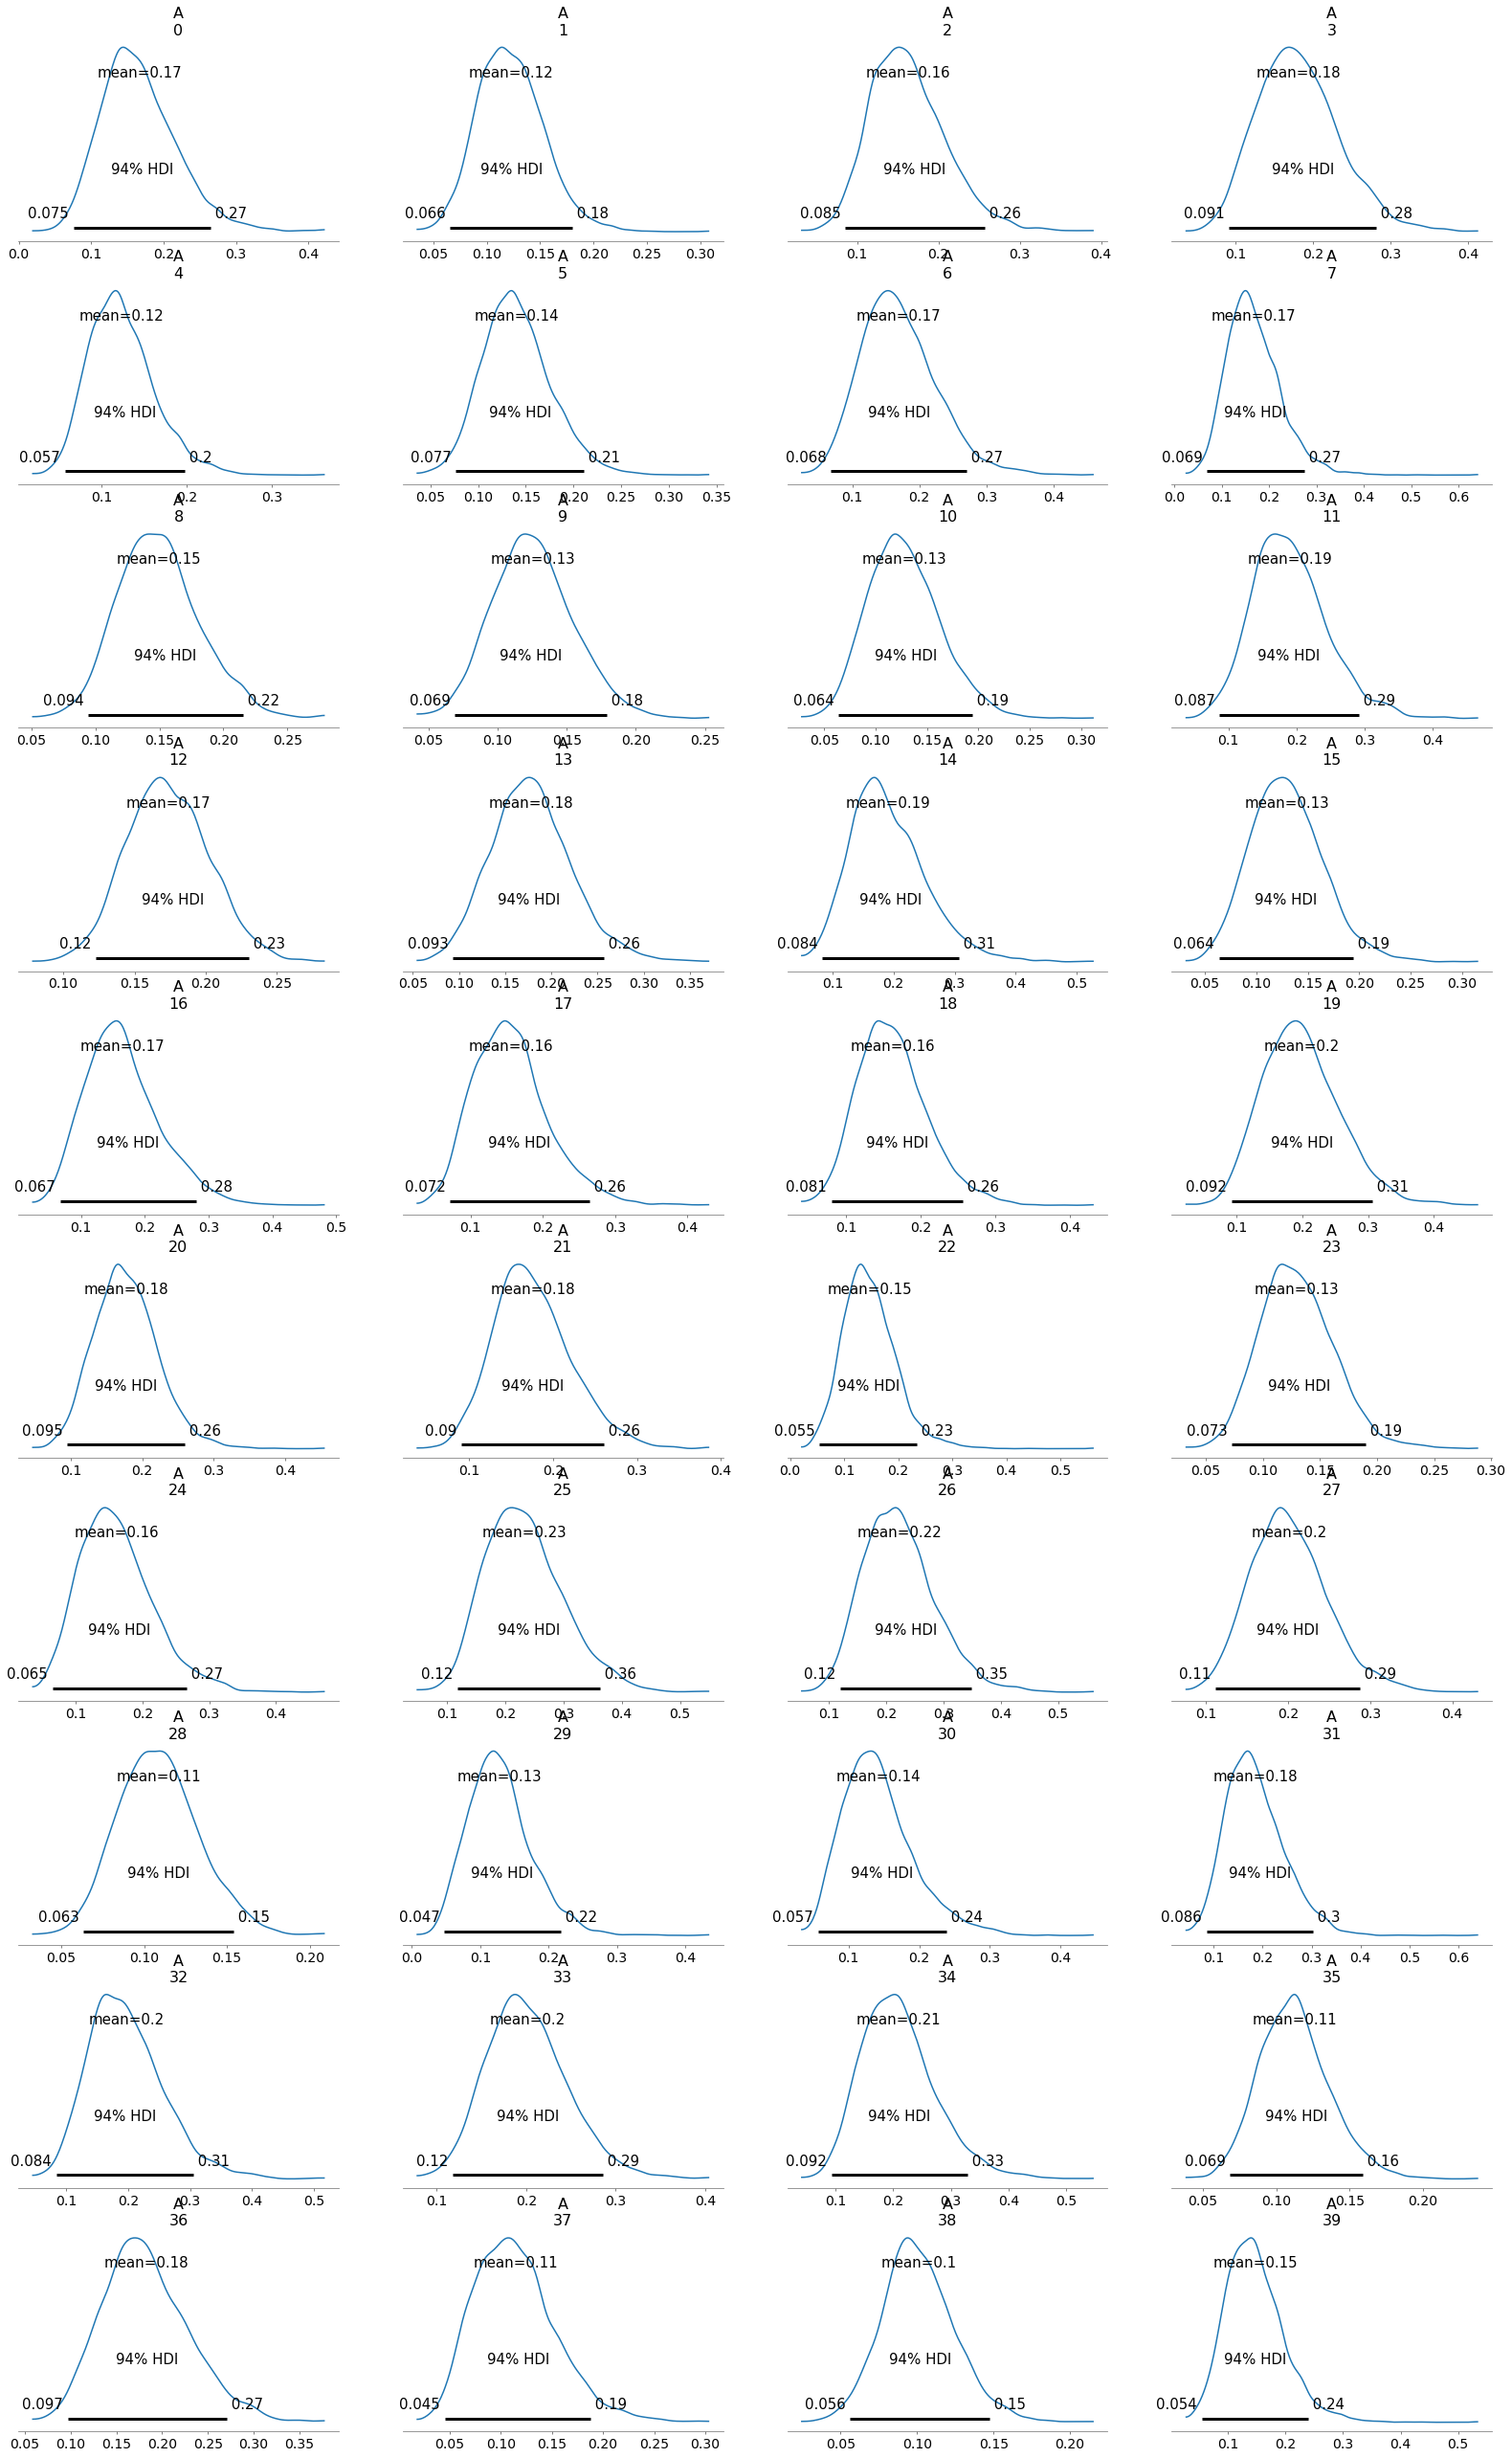

In [13]:
az.plot_posterior(model, var_names=['A'])

Uncertainty is very big. 